In [ ]:
# notebook to run all the seismic analysis and processing in Olinger et al 2021

In [2]:
import numpy as np
import pathlib
import time
import h5py
import obspy
from obspy.clients.fdsn.mass_downloader import RectangularDomain, Restrictions, MassDownloader
import types
import pyasdf
import pickle
import rasterio
import math
import glob
import os
from datetime import datetime, timedelta
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from detection.stalta_detector import stalta_detector
from detection.master_event_correlation import correlate_master, threshold_detections, plot_catalog
from detection.template_match import make_templates, template_match, detection_timeseries
from clustering.clustering import get_input_waveforms, load_waveform, cluster_events, plot_clusters
from location.compute_backazimuths import compute_backazimuths, get_detection_times
from figures.figures import (plot_backazimuths_on_imagery, transform_imagery, get_station_coordinates, 
                             get_station_grid_locations, plot_daily_events_and_gps, plot_weekly_events_and_gps)
from stacking.stacking import get_rotated_waveforms, get_stacks
from gps.gps import gps_ice_speed

In [ ]:
'''

Download data and remove instrumental response

'''

# specify path to save data- directories will be created here for MSEED and XML
# default is the provided "data" folder, but change the path below to put data elsewhere on your filesystem
#data_path = "/media/Data/Data/PIG/MSEED/"
data_path = "data/"

# pull data from IRIS servers
domain = RectangularDomain(minlatitude=-90, maxlatitude=90, minlongitude=-180, maxlongitude=180.0)

restrictions = Restrictions(
    starttime=obspy.UTCDateTime(2012, 1, 1),
    endtime=obspy.UTCDateTime(2014, 1, 1),
    chunklength_in_sec=86400,
    network="XC", station="PIG2", location="", channel="HH*",
    location_priorities = ["01",],
    channel_priorities = ["HHZ","HHN","HHE"],
    reject_channels_with_gaps=False,
    minimum_length=0.0)

mdl = MassDownloader(providers=["IRIS"])

mdl.download(
    domain=domain,
    restrictions=restrictions, 
    mseed_storage=data_path + "MSEED/raw/", 
    stationxml_storage=(data_path + "XML/"))

#set frequency band for response removal
pre_filt = [0.0005,0.001,45,50]

#make a list of all files in the raw folder
raw_files = glob.glob(data_path + "MSEED/raw/*", recursive=True)
raw_files.sort()

#loop through all raw files
for f in raw_files:

    #start timer
    t = time.time()

    #read in one data file
    st = obspy.read(f)

    #grab a couple useful variables from file metadata
    station = st[0].stats.station
    channel = st[0].stats.channel
    start_date = str(st[0].stats.starttime).split("T")[0]

    #specify output filename format
    out_path = data_path + "MSEED/no_IR/" + station + "/" + channel + "/" 
    out_file = out_path + start_date + "." + station + "." + channel + ".no_IR.MSEED"
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    
    #preprocess file
    st.detrend("demean")
    st.detrend("linear")
    st.taper(max_percentage=0.00025, max_length=20.)

    #read correct stationXML file
    XML_path = glob.glob(data_path + "XML/*" + station + "*.xml")[0]
    inv = obspy.read_inventory(XML_path)

    #remove instrument response
    st.remove_response(inventory=inv,pre_filt=pre_filt,output="VEL")

    #write new file
    st.write(out_file,format='MSEED')

    #end timer
    run_time = time.time() - t

    #give some output to check progress
    print("Response removed from " + f + " in " + str(run_time) + " seconds.")

In [ ]:
'''

Run 2-band sta-lta detector to find template events

'''

# initialize detection parameter object and set parameters for stalta
d = types.SimpleNamespace()
d.low_freq = [0.01,1]
d.high_freq = [1,10]
d.tolerance = 120
d.low_thresh_on = 8
d.low_thresh_off = 2
d.high_thresh_on = 20
d.high_thresh_off = 2
d.sta_len = 10
d.lta_len = 300
d.num_stations = 3

# specify window to pull template around detection in seconds
d.buffer = [2*60,3*60]

# specify paths to data and metadata
d.data_path = "data/MSEED/no_IR/"
d.xml_path = "data/XML/"

# select number of processors
d.n_procs = 10

# run the detector and save ASDF dataset with waveforms and metadata
stalta_detector(d)

In [ ]:
'''

Cross correlate master event with the rest of the detections to identify best templates

'''

# set normalized cross correlation threshold for making templates
threshold = 0.9

# load catalog in read-only mode
ds = pyasdf.ASDFDataSet("outputs/detections/stalta_catalog.h5",mode='r')

# get waveforms for a single station 
waveforms = ds.waveforms.XC_PIG2.stream

# filter waveforms
freq = [0.05,1]
waveforms.taper(max_percentage=0.1, max_length=30.)
waveforms.filter("bandpass",freqmin=freq[0],freqmax=freq[1])

# set master event for correlation after plotting to see if it looks dispersive and has high SNR
for station in ds.ifilter(ds.q.starttime == "2013-07-10T00:33:54.290001Z",ds.q.station=="PIG2"):
    master_event = station.stream
    master_event.taper(max_percentage=0.1, max_length=30.)
    master_event.filter("bandpass",freqmin=freq[0],freqmax=freq[1])
    master_event.plot()
    
# correlate master with all other waveforms
correlation_coefficients, shifts = correlate_master(master_event,waveforms,master_event[0].stats.npts,"stalta")

# apply threshold to choose best templates and make plots
threshold_detections(waveforms,correlation_coefficients,shifts,threshold)

# close ASDF dataset
del ds

In [ ]:
'''

Make ASDF dataset of templates for use in multiband template matching procedure

''' 

# set frequency limits for low and high frequency templates
low_freq = [0.05,1]
high_freq = [1,10]

# load catalog in read-only mode
ds = pyasdf.ASDFDataSet("outputs/detections/stalta_catalog.h5",mode='r')

# load list of template times
template_file = h5py.File('outputs/detections/template_times.h5', 'r')
template_times = list(template_file['timestamps'])
template_file.close()

# make all the templates
make_templates(ds,template_times,high_freq,low_freq,xml_path)

In [ ]:
'''

Plot each template to verify quality

''' 

# open ASDF dataset 
ds = pyasdf.ASDFDataSet("outputs/detections/templates.h5",mode='r')

# make plot of both frequency bands 
for event in ds.events:
    for station in ds.ifilter(ds.q.event == event):
        station.low.plot()
        station.high.plot()

In [ ]:
'''

Delete a few templates that are unsuitable for use in template matching

''' 

# delete a specific station's record of a particular event
for station in ds.ifilter(ds.q.starttime == "2013-03-23T05:46:55.24",ds.q.station == "PIG4"):
    del station.low
    del station.high
    
# close the dataset
del ds

In [ ]:
'''

Run 2-band template matching detection procedure

'''

# initialize detection parameter object and set parameters for template matching
d = types.SimpleNamespace()
d.low_freq = [0.05,1]
d.high_freq = [1,10]
d.tolerance = 120
d.low_thresh_on = 0.3
d.low_thresh_off = 0.1
d.high_thresh_on = 0.2
d.high_thresh_off = 0.1
d.num_stations = 3

# specify window to pull template around detection in seconds
d.buffer = [2*60,3*60]

# specify paths to data and metadata
d.data_path = "data/MSEED/no_IR/"
d.xml_path = "data/XML/"
                            
# select number of processors
d.n_procs = 18

# run the parallel template matching code
template_match(d)

In [ ]:
'''

Plots the results of template matching

'''

# load catalog
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='a')

# make basic histogram of detection times
detection_timeseries(ds,"outputs/detections/template_matching_timeseries.png")

# get waveforms for a single station 
ds.single_item_read_limit_in_mb=6000
waveforms = ds.waveforms.XC_PIG2.stream

# filter waveforms
freq = [0.05,1]
waveforms.taper(max_percentage=0.1, max_length=30.)
waveforms.filter("bandpass",freqmin=freq[0],freqmax=freq[1])

# set master event for correlation after plotting to see if it looks dispersive and has high SNR
for station in ds.ifilter(ds.q.starttime == "2013-07-10T00:33:55.240001Z" ,ds.q.station=="PIG2"):
    master_event = station.stream
    master_event.taper(max_percentage=0.1, max_length=30.)
    master_event.filter("bandpass",freqmin=freq[0],freqmax=freq[1])
    master_event.plot()
    
# correlate master with all other waveforms
correlation_coefficients, shifts = correlate_master(master_event,waveforms,master_event[0].stats.npts,"detection/template_matching")

# make plot of detected event waveforms
plot_catalog(waveforms,correlation_coefficients,shifts)

# close ASDF dataset
del ds

In [ ]:
'''

Get waveforms for k-shape clustering

'''

# load catalog in read-only mode
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')

# initialize  parameter object and set parameters for clustering
c = types.SimpleNamespace()
c.station = "PIG2"
c.component_order = ["Z","N","E"]
c.freq = [0.05,5]
c.num_clusters = 2
c.trace_length = 500
#c.data_path = "data/MSEED/no_IR/"
c.data_path = "/media/Data/Data/PIG/MSEED/noIR/"

# get matrix of 3D waveforms from a single station
waveforms = get_input_waveforms(ds,c)

# save waveforms
waveform_file = h5py.File("outputs/clustering/input_waveforms.h5",'w')
waveform_file.create_dataset("waveforms",data=waveforms)
waveform_file.close()

In [ ]:
'''

Cluster the catalog with k-shape

'''

# load catalog in read-only mode
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')

# initialize  parameter object and set parameters for clustering
c = types.SimpleNamespace()
c.station = "PIG2"
c.component_order = ["Z","N","E"]
c.freq = [0.05,5]
c.num_clusters = 2
c.trace_length = 500
#c.data_path = "data/MSEED/no_IR/"
c.data_path = "/media/Data/Data/PIG/MSEED/noIR/"

# load waveforms
waveform_file = h5py.File("outputs/clustering/input_waveforms_high_frequency.h5",'r')
waveforms = np.array(waveform_file['waveforms'])
waveform_file.close()

# run clustering
cluster_events(c,waveforms)

# close dataset
del ds

In [ ]:
'''

Cross-correlate clustered waveforms with the centroid of their cluster and plot

'''

# load waveforms
waveform_file = h5py.File("outputs/clustering/input_waveforms.h5",'r')
waveforms = np.array(waveform_file['waveforms'])
waveform_file.close()

# load clustering results
cluster_file = h5py.File("outputs/clustering/" + str(c.num_clusters) + "_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

# shift centroids to center (kshape sometimes outputs centroids that are shifted to the sides input window which can cause further alignment issues later). The shift values for the correction done here are obtained simply by plotting the centroids. 
centroids[0] = np.concatenate((centroids[0].ravel()[550:],np.zeros(550)))
centroids[1] = np.concatenate((np.zeros(400),centroids[1].ravel()[:-400]))

# load catalog
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')

for cluster in range(len(centroids)):
    
    # get obspy stream with centroid
    master_event = obspy.Stream(obspy.Trace(centroids[cluster]))

    # put 3-component waves used for clustering in obspy streams
    waveform_stream = obspy.Stream([])
    for waveform in waveforms[predictions == cluster]:
        waveform_stream += obspy.Trace(waveform)
    
    # correlate waves in each cluster with their centroid
    correlation_coefficients, shifts = correlate_master(master_event,waveform_stream,math.floor(master_event[0].stats.npts/3),"clustering/cluster_"+str(cluster))

    # read correlation results
    correlation_file = h5py.File("outputs/clustering/cluster_" + str(cluster) + "_correlations.h5",'r')
    correlation_coefficients = np.array(correlation_file['correlation_coefficients'])
    shifts = np.array(correlation_file['shifts'])
    correlation_file.close()
    
    # make plots of waveforms from each cluster
    plot_clusters(c,cluster,centroids[cluster],waveforms[predictions == cluster],correlation_coefficients,shifts)
    
    # make basic histogram of detection times for this cluster
    detection_timeseries(ds,"outputs/clustering/cluster_" + str(cluster) + "_timeseries.png",cluster,predictions)
    
# close ASDF dataset
del ds

In [ ]:
'''

Compute backazimuths for all events in the catalog

'''

# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()
l.win_len = 50
l.slide = 5
l.trace_len = 500
l.num_steps = int((l.trace_len-l.win_len)/l.slide)+1
l.stations = ["PIG1","PIG2","PIG3","PIG4","PIG5"]
l.network = "XC"

# load catalog
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')
l.detection_times = get_detection_times(ds)

# set the coordinate system in which we will do all grid-based calculations
l.crs = "EPSG:3245"

# set signal-to-noise ratio for throwing out stations in backazimuth computation
l.snr_threshold = 0

# set sta/lta ratio for throwing out individual windows in backazimuth computation
l.stalta_threshold = 1

# specify method for correcting pca components 
l.pca_correction = "distance"
l.centroid = "fixed"

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000
l.freq = [0.05,1]
l.fs = 100

# specify paths to data and me tadata
#l.data_path = "data/MSEED/no_IR/"
#l.xml_path = "data/XML/"
l.data_path = "/media/Data/Data/PIG/MSEED/noIR/"
l.xml_path = "/media/Data/Data/PIG/XML/HH/"
l.filename = "outputs/locations/event_backazimuths_" + '_'.join(l.stations) + "_" + l.pca_correction + "_pca_" + l.centroid + "_centroid_long_window"
l.n_procs = 10

# run the backazimuth code
b = compute_backazimuths(l)

# save the output
baz_file = open(l.filename + ".pickle", "wb")
pickle.dump(b, baz_file)
baz_file.close()

In [ ]:
'''

Make the backazimuth figure in Olinger et al, 2021

'''

# load the results of polarization analysis
baz_file = open("outputs/locations/event_backazimuths_PIG1_PIG2_PIG3_PIG4_PIG5_distance_pca_fixed_centroid.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()

# get backazimuths of only the events in the dispersive cluster (cluster 0)
backazimuths = b.backazimuths

# load clustering results
cluster_file = h5py.File("outputs/clustering/2_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

# get station locations and array centroids
station_lon_lat_coords = get_station_coordinates("data/XML/")
station_grid_coords = get_station_grid_locations(station_lon_lat_coords,"epsg:3245")
array_centroid = np.mean(station_grid_coords,axis=0)

# open LANDSAT imagery file
file = "data/imagery/LC08_L1GT_001113_20131012_20170429_01_T2_B4.TIF"
transform_imagery(file,'epsg:3245')

# set where to split the distribution and which color to use for each
color_bounds = [[0,120],[180,280],[280,360]]
colors = ["#7570b3","#d95f02","#1b9e77"]

# make the figure
plot_backazimuths_on_imagery(backazimuths[predictions == 0],array_centroid,station_grid_coords,color_bounds,colors)

In [ ]:
'''

Get rotated waveforms for use in plotting and MATLAB modeling

'''

# load catalog in read-only mode and extract times for each event in the dataset
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')
detection_times = []
for event in ds.events:
    detection_times.append(event.origins[0].time.datetime)
detection_times = np.array(detection_times)

# load the results of polarization analysis
baz_file = open('outputs/locations/event_backazimuths_PIG1_PIG2_PIG3_PIG4_PIG5_distance_pca_fixed_centroid.pickle', "rb")
b = pickle.load(baz_file)
backazimuths = b.backazimuths
baz_file.close()

# load clustering results
cluster_file = h5py.File("outputs/clustering/2_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

# initialize  parameter object and set parameters for clustering
r = types.SimpleNamespace()
r.station = "PIG2"
r.channel = "HH*"
r.component_order = ["Z","R","T"]
r.num_clusters = 2
r.trace_length = 500
r.backazimuths = backazimuths[predictions == 0]
r.detection_times = detection_times[predictions == 0]
#r.data_path = "data/MSEED/no_IR/"
r.data_path = "/media/Data/Data/PIG/MSEED/noIR/"
r.n_procs = 15

# get matrix of 3D waveforms from a single station on first frequency band
r.freq = [0.01,1]
waveforms_stack = get_rotated_waveforms(r)

# get matrix of 3D waveforms from a single station on second frequency band
r.freq = [0.05,1]
waveforms_corr = get_rotated_waveforms(r)

# save waveforms
waveform_file = h5py.File("outputs/stacking/rotated_waveforms_PIG2_0.01Hz.h5",'w')
waveform_file.create_dataset("waveforms_0.01-1Hz",data=waveforms_stack)
waveform_file.create_dataset("waveforms_0.05-1Hz",data=waveforms_corr)
waveform_file.close()

In [ ]:
'''

Get daily stacks of vertical and radial event waveforms for plotting and modeling 

'''

# set some parameters
freq = [0.05,1]
trace_length = 500
cluster = 0

# load waveforms
waveform_file = h5py.File("outputs/stacking/rotated_waveforms_PIG2_0.001Hz.h5",'r')
waveforms_stack = np.array(waveform_file['waveforms_0.001-1Hz'])
waveforms_corr = np.array(waveform_file['waveforms_0.05-1Hz'])
waveform_file.close()

# load clustering results
cluster_file = h5py.File("outputs/clustering/2_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

# read correlation results
correlation_file = h5py.File("outputs/clustering/cluster_0_correlations.h5",'r')
correlation_coefficients = np.array(correlation_file['correlation_coefficients'])
shifts = np.array(correlation_file['shifts'])
correlation_file.close()

# load the results of polarization analysis
baz_file = open('outputs/locations/event_backazimuths_PIG1_PIG2_PIG3_PIG4_PIG5_distance_pca_fixed_centroid.pickle', "rb")
b = pickle.load(baz_file)
backazimuths = b.backazimuths
baz_file.close()

# load catalog
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')
detection_dates = []
for event in ds.events:
    detection_dates.append(event.origins[0].time.datetime.date())

# subset everything by the desired cluster
detection_dates = np.array(detection_dates)[predictions == cluster]
#waveforms = waveforms[predictions == cluster]
backazimuths = backazimuths[predictions == cluster]
baz_bounds = [[180,280],[280,360],[0,120]]

# make daily waveform stacks for each spatial cluster
bool_indices = np.logical_and(backazimuths>=180,backazimuths<280)
rift_tip_daily_stacks,rift_tip_stack = get_stacks(waveforms_stack[bool_indices],waveforms_corr[bool_indices],detection_dates[bool_indices],correlation_coefficients[bool_indices],cluster,shifts[bool_indices],freq,trace_length)
bool_indices = np.logical_and(backazimuths>=0,backazimuths<120)
ne_margin_daily_stacks,ne_margin_stack = get_stacks(waveforms_stack[bool_indices],waveforms_corr[bool_indices],detection_dates[bool_indices],correlation_coefficients[bool_indices],cluster,shifts[bool_indices],freq,trace_length)
bool_indices = np.logical_and(backazimuths>=280,backazimuths<360) 
rift_margin_daily_stacks,rift_margin_stack = get_stacks(waveforms_stack[bool_indices],waveforms_corr[bool_indices],detection_dates[bool_indices],correlation_coefficients[bool_indices],cluster,shifts[bool_indices],freq,trace_length)

# save stacks
stack_file = h5py.File("outputs/stacking/stacks_PIG4_0.01Hz.h5",'w')
stack_file.create_dataset("rift_tip_daily_stacks",data=rift_tip_daily_stacks)
stack_file.create_dataset("ne_margin_daily_stacks",data=ne_margin_daily_stacks)
stack_file.create_dataset("rift_margin_daily_stacks",data=rift_margin_daily_stacks)
stack_file.create_dataset("rift_tip_stack",data=rift_tip_stack)
stack_file.create_dataset("ne_margin_stack",data=ne_margin_stack)
stack_file.create_dataset("rift_margin_stack",data=rift_margin_stack)
stack_file.close()

# close ASDF dataset
del ds

In [ ]:
'''

Estimate noise level in non-event windows so we can show that variability in event counts is not simply a function of detectability

'''

# load catalog
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')

# get vertical waveforms for a single station 
ds.single_item_read_limit_in_mb=6000
waveforms = ds.waveforms.XC_PIG2.stream
waveforms.filter("bandpass",freqmin=0.05,freqmax=1)
component_waveforms = waveforms.select(component="Z")

# get the first minute of event event window (contains noise) and calculate noise rms
date_vector = np.array([])
noise_rms_vector = np.array([])
for w in component_waveforms:
    noise_window = w.trim(w.stats.endtime-60,w.stats.endtime)
    squared_trace = np.square(np.array(noise_window.data,dtype='float64'))
    noise_rms = np.sqrt(np.sum(squared_trace)/len(squared_trace))
    noise_rms_vector = np.append(noise_rms_vector,noise_rms)
    date_vector = np.append(date_vector,noise_window.stats.starttime.date)
noise_date_vect = np.unique(date_vector)
    
# get weekly iterator
weeks = np.arange(noise_date_vect[0],noise_date_vect[-1],timedelta(days=7)).astype(datetime)
    
# get average noise rms for each day
noise_vect = np.array([])
for w in range(len(weeks)-1):
    bool_ind = np.logical_and(date_vector>=weeks[w].date(),date_vector<weeks[w+1].date())
    mean_rms = np.mean(noise_rms_vector[bool_ind])
    noise_vect = np.append(noise_vect,mean_rms)
noise_vect = np.append(noise_vect,np.mean(noise_rms_vector[date_vector>weeks[-1].date()]))
    
# save result
noise_file = open("outputs/figures/noise.pickle", "wb")
pickle.dump([weeks,noise_vect],noise_file)
noise_file.close()

In [ ]:
'''

Get ice speed from pre-processed GPS solutions 

'''

# select GPS source
station = "sow3"

# set some parameters for linearly interpolating ice speed data to replace spike artifacts from numerical differentiation
spike_height = 2e-5
kde_width = 2.5

# get the gps ice speed curve
gps_speed,gps_time_vect = gps_ice_speed(station,spike_height,kde_width)

# get rid of some artifacts at the front of the data
gps_speed = gps_speed[2:]
gps_time_vect = gps_time_vect[2:]

# design a lowpass filter- the gps ice speed we calculated are average values for each day, so fs = 1/86400
fs = 1/86400
ny = fs/2
cutoff = fs/6
b, a = butter(4, cutoff/ny, 'low')

# lowpass filter the gps ice speed
filt_gps_speed = filtfilt(b, a, gps_speed)

# convert from m/s to m/yr
filt_gps_speed = filt_gps_speed * 86400 * 365

# save result
gps_file = open("outputs/figures/gps.pickle", "wb")
pickle.dump([filt_gps_speed,gps_time_vect],gps_file)
gps_file.close()

In [ ]:
'''

Plot timeseries of dispersive cluster events with waveforms and GPS ice velocity

'''

# set some parameters for the plot
cluster = 0
num_clusters = 2

# load catalog
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')

# extract times for each event in the dataset
detection_times = []
for event in ds.events:
    detection_times.append(event.origins[0].time.datetime)

# load the results of polarization analysis
baz_file = open('outputs/locations/event_backazimuths_PIG1_PIG2_PIG3_PIG4_PIG5_distance_pca_fixed_centroid.pickle', "rb")
b = pickle.load(baz_file)
backazimuths = b.backazimuths
baz_file.close()
    
# load clustering results
cluster_file = h5py.File("outputs/clustering/" + str(num_clusters) + "_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

# read daily stacks of waveforms
home_dir = str(pathlib.Path().absolute())
stack_file = h5py.File("outputs/stacking/stacks.h5",'r')
rift_tip_daily_stacks = np.array(stack_file["rift_tip_daily_stacks"])
rift_margin_daily_stacks = np.array(stack_file["rift_margin_daily_stacks"])
ne_margin_daily_stacks = np.array(stack_file["ne_margin_daily_stacks"])
daily_stacks = [rift_tip_daily_stacks,rift_margin_daily_stacks,ne_margin_daily_stacks]
rift_tip_stack = np.array(stack_file["rift_tip_stack"])
rift_margin_stack = np.array(stack_file["rift_margin_stack"])
ne_margin_stack = np.array(stack_file["ne_margin_stack"])
stacks = [rift_tip_stack,rift_margin_stack,ne_margin_stack]
stack_file.close()

# load noise
noise_file = open("outputs/figures/noise.pickle", "rb")
noise_date_vect,noise_vect = pickle.load(noise_file)
noise_file.close()

# load gps
gps_file = open("outputs/figures/gps.pickle", "rb")
filt_gps_speed,gps_time_vect = pickle.load(gps_file)
noise_file.close()

# set where to split the distribution and which color to use for each
baz_bounds = [[180,280],[280,360],[0,120]]
colors = ["#d95f02","#1b9e77","#7570b3"]

# make the plot
plot_weekly_events_and_gps(filt_gps_speed,gps_time_vect,noise_vect,noise_date_vect,np.array(detection_times)[predictions==cluster],daily_stacks,stacks,colors,baz_bounds,backazimuths[predictions==cluster])

In [3]:
# read daily stacks of waveforms
home_dir = str(pathlib.Path().absolute())
stack_file = h5py.File("outputs/stacking/stacks_PIG2_0.01Hz.h5",'r')
rift_tip_daily_stacks = np.array(stack_file["rift_tip_daily_stacks"])
rift_margin_daily_stacks = np.array(stack_file["rift_margin_daily_stacks"])
ne_margin_daily_stacks = np.array(stack_file["ne_margin_daily_stacks"])
daily_stacks = [rift_tip_daily_stacks,rift_margin_daily_stacks,ne_margin_daily_stacks]
rift_tip_stack = np.array(stack_file["rift_tip_stack"])
rift_margin_stack = np.array(stack_file["rift_margin_stack"])
ne_margin_stack = np.array(stack_file["ne_margin_stack"])
stacks = [rift_tip_stack,rift_margin_stack,ne_margin_stack]
stack_file.close()

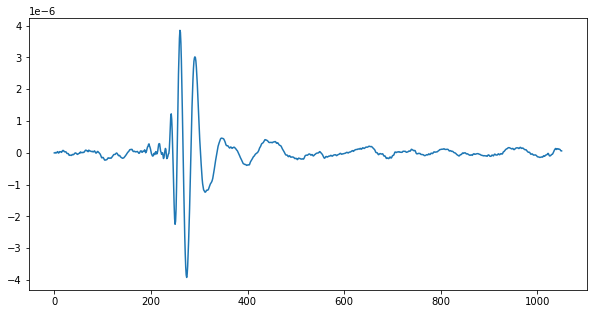

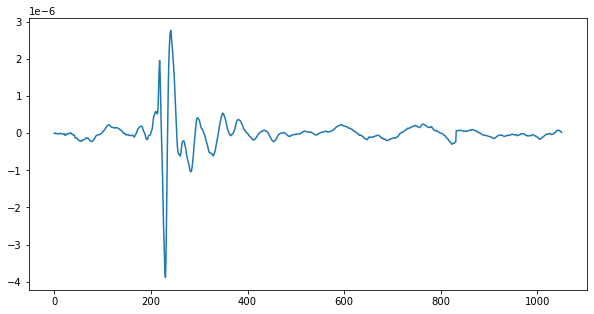

In [9]:
plt.figure(figsize=(10,5))
plt.plot(rift_tip_stack[0])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(rift_tip_stack[1])
plt.show()

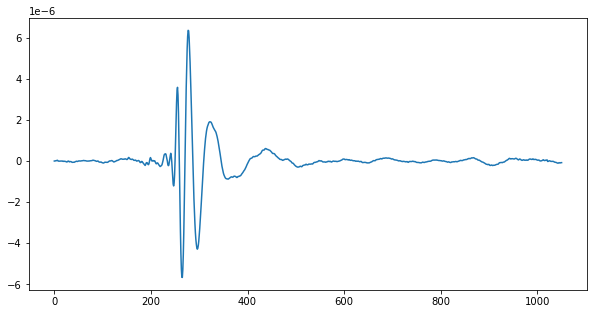

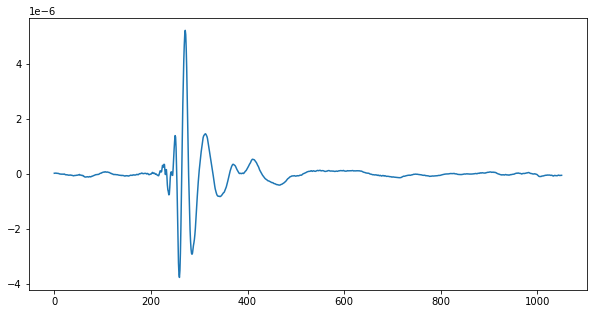

In [11]:
plt.figure(figsize=(10,5))
plt.plot(rift_margin_stack[0])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(rift_margin_stack[1])
plt.show()

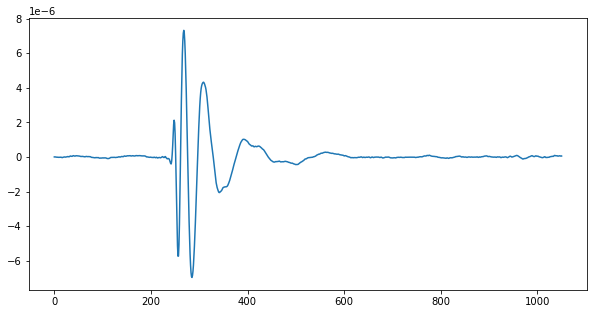

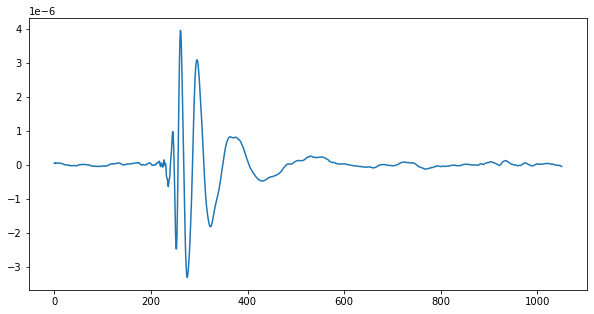

In [10]:
plt.figure(figsize=(10,5))
plt.plot(ne_margin_stack[0])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(ne_margin_stack[1])
plt.show()

In [ ]:
stack_file = h5py.File("outputs/figures/stacks_only.h5",'r')
rift_tip_stack = np.array(stack_file["rift_tip_stack"])

In [ ]:
plt.plot(rift_tip_stack[1051:1051*2])
plt.show()